In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, AutoMinorLocator

In [2]:
from matplotlib import rcParams
font_size = 17
rcParams['axes.titlesize'] = font_size - 1
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = font_size - 2
rcParams['xtick.labelsize'] = font_size - 2
rcParams['ytick.labelsize'] = font_size - 2
rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size 
rcParams['figure.titleweight'] = 'bold'

## Read Climate TRACE data

In [3]:
data_dir = '../data/ClimateTrace/waste/'
df = pd.read_csv(data_dir+'solid-waste-disposal_emissions-sources.csv')

# select ch4 and use newest data
df = df[(df['gas']=='ch4')].sort_values(['source_id', 'start_time']).drop_duplicates(subset='source_id', keep='last')

# add lon lat columns
df[['lon', 'lat']] = df['geometry_ref'].str.split('_', expand=True).rename(columns={1:'lon', 2:'lat'})[['lon', 'lat']]

# rename columns
df.rename(columns={'other1': 'metadata_source', 'other4': 'emissions_estimation_method',
                          'other5': 'metadata_reported_year',  'other6': 'operating_status'},
                          inplace=True)

/var/folders/n2/jdncdjcx465bv0ls_nyvsqx40000gn/T/ipykernel_29290/1864384274.py:2: DtypeWarning: Columns (18,22,23,27,28,32,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_dir+'solid-waste-disposal_emissions-sources.csv')


## Read HSI summary data

In [4]:
ds_hsi = pd.read_csv('../data/landfills_hyper_summary.csv')
emission_landfill = ds_hsi.groupby(['country', 'name'], as_index=False).agg({'emission':'mean'})['emission']

In [5]:
def plot_cdf(data, ax, twinaxis='log'):
    # Fig 5 of https://www.pnas.org/doi/full/10.1073/pnas.1605617113

    # Step 1: Sort the emission data in descending order
    sorted_data = np.sort(data)[::-1]

    # Step 2: Calculate the cumulative sum of the sorted data
    cumulative_sum = np.cumsum(sorted_data)

    # Step 3: Calculate the percentile values for the emission data
    percentiles = np.linspace(0, 100, len(sorted_data))

    # Step 4: Plot the CDF of the summed fluxes against the flux percentiles
    ax.plot(percentiles, cumulative_sum / np.sum(sorted_data), '-', c='k')#, label='CDF')
    # ax.set_xlabel('Percentile (%) of Plumes (High to Low)')
    # ax.set_ylabel('Total Emission Pcercentage')
    # ax.axhline(y=0.6, c='darkgray', linestyle='--')
    # ax.hlines(y=0.4, xmin=0, xmax=15, color='darkgray', linestyle='--')

    # Step 5: Plot the emission at the respective percentiles as a red line
    ax2 = ax.twinx()
    if twinaxis == 'log':
        ax2.set_yscale('log')
        ax2.set_ylabel('Emission Rate (t h$^{-1}$)', c='C0')
    ax2.set_yscale('log')
    ax2.plot(percentiles, sorted_data, '-', c='C0')#, label='Emission Rates')
    # ax2.hlines(y=7, xmin=0.1, xmax=100, color='darkgray', linestyle='--')
    # ax2.hlines(y=.5, xmin=0.1, xmax=100, color='darkgray', linestyle='--')
    # ax2.text(102, 9, 9, c='gray', size=font_size-2)

/var/folders/n2/jdncdjcx465bv0ls_nyvsqx40000gn/T/ipykernel_29290/1560839898.py:27: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(xmin=0, xmax=100)


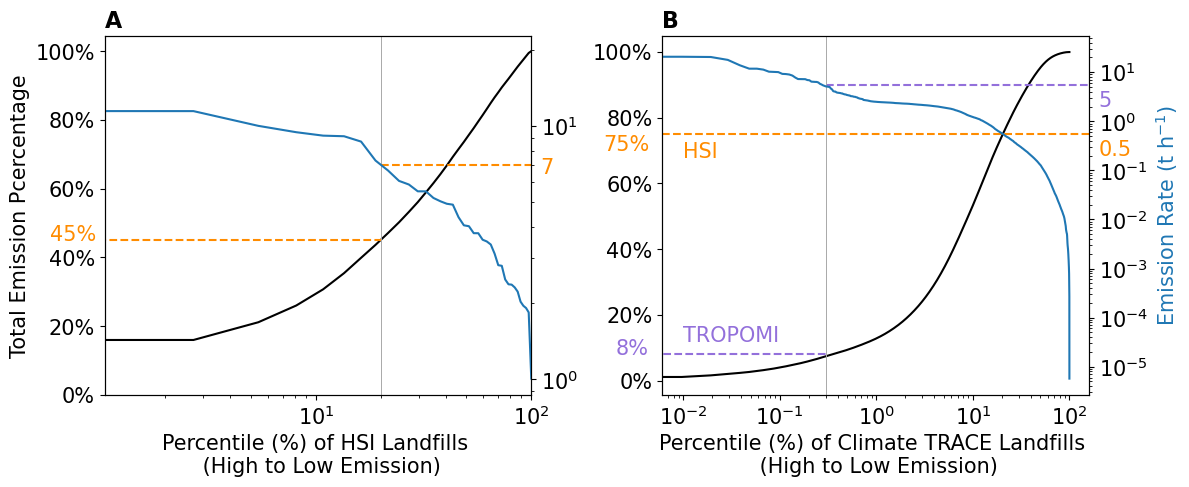

In [6]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

axs = axs.flatten()

for ax in axs:
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# ----------- HSI -----------
ax = axs[0]
ax.set_xscale('log')

plot_cdf(emission_landfill, ax, twinaxis=None)

ax.set_xlabel('Percentile (%) of HSI Landfills \n (High to Low Emission)')
ax.set_ylabel('Total Emission Pcercentage')
# ax.axhline(y=0.70, c='darkorange', linestyle='--')
ax.axvline(x=20, c='darkgray', linestyle='-', linewidth=0.7)
ax.hlines(y=.67, xmin=20, xmax=100, color='darkorange', linestyle='--')  # 7 t/h
ax.hlines(y=.45, xmin=.01, xmax=20, color='darkorange', linestyle='--')

ax.text(0.58, 0.45, '45%', c='darkorange', size=font_size-2)
plt.text(110, 6.5, 7, c='darkorange', size=font_size-2)

# ax.xaxis.set_minor_locator(AutoMinorLocator(4))

ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0, xmax=100)


# ----------- Climate TRACE -----------
ax = axs[1]
# t/yr
plot_cdf(df['emissions_quantity']/365/24, ax)

ax.set_xlabel('Percentile (%) of Climate TRACE Landfills \n (High to Low Emission)')
ax.set_ylabel('')
ax.set_xscale('log')

# TROPOMI detection limit
ax.text(.01, .12, 'TROPOMI', c='mediumpurple', size=font_size-2)
ax.hlines(y=0.08, xmin=1e-3, xmax=0.3, color='mediumpurple', linestyle='--')
ax.hlines(y=0.9, xmin=0.3, xmax=1e3, color='mediumpurple', linestyle='--')
plt.text(200, 2, 5, c='mediumpurple', size=font_size-2)
ax.text(.002, .08, '8%', c='mediumpurple', size=font_size-2)

# HSI detection limit
ax.text(.01, .68, 'HSI', c='darkorange', size=font_size-2)
ax.axhline(y=0.75, c='darkorange', linestyle='--')
plt.text(200, .2, .5, c='darkorange', size=font_size-2)
ax.text(.0015, .7, '75%', c='darkorange', size=font_size-2)

# vertical line
ax.axvline(x=0.3, c='darkgray', linestyle='-', linewidth=0.7)

axs[0].set_title('A', x=0.02, y=1.1, pad=-20)
axs[1].set_title('B', x=0.02, y=1.1, pad=-20)


fig.tight_layout()
fig.savefig('../figures/emission_cdf.pdf')

In [7]:
# total landfill emissions from ClimateTRACE
df['emissions_quantity'].sum()/1e6  # t/yr --> Tg/yr

36.7509102

In [8]:
print('Total Climate TRACE landfill numbers: ', len(df))

Total Climate TRACE landfill numbers:  10314
